In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state, test_size
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *
from src.models import ExpandingPredictionOLS, SKLearnWrapOLS

In [4]:
# Load data
model_type = "ols"
tinterval = 'daily'

year_start = 2012
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

variables = 'FF_TS_VX' #'FF' # 'FF_TS_VX'

name = f'{tinterval}_{variables}_{year_spread}'

df_w = load_data(file_name=f"df_{name}.csv", file_path=OUT_DATA_DIR)
data_dict = load_data(file_name=f"dict_{name}.pkl", file_path=OUT_DATA_DIR)

In [5]:
# update dict with model specific information
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(variables=variables)
data_dict["model_metrics"].update(tinterval=tinterval)
data_dict["model_metrics"].update(model_name=f"{model_type}_{name}_{data_dict['model_features']['predicted']}")

# data selection

In [6]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
     'vixo',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     'macd',
     'williamsr',
     'termspread',
     'sp_close',
     # 'sp_close_lag1',
     # 'sp_close_lag2',
     'sp_close_lag3',
     # 'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     # 'sp_close_lag8',
     # 'sp_close_lag9',
     # 'sp_close_lag10',
     # 'sp_close_lag11',
     'sp_close_lag12',
     # 'sp_close_lag13',
     # 'sp_close_lag14',
     # 'sp_close_lag15'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [7]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

# TTS

In [8]:
df_train = df_ws.copy()

In [9]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=test_size,
                                            add_const=False)

# Corr

In [10]:
# merging X, y for analysis purposes only
X_train = pd.concat([X_train, y_train], axis=1)

Corr matrix

,VIF,corr_sp_close_lead1
sp_close,1.489199,-0.182489
sp_close_lag7,1.153089,-0.147732
sp_close_lag5,1.133137,-0.132706
sp_close_lag12,1.115781,-0.111969
sp_close_lag3,1.158144,-0.071968
ff_HML,1.585746,-0.031879
williamsr,3.845996,-0.030617
macd,1.380891,-0.026917
ff_RMW,1.095224,0.004679
ff_CMA,1.484461,0.013257


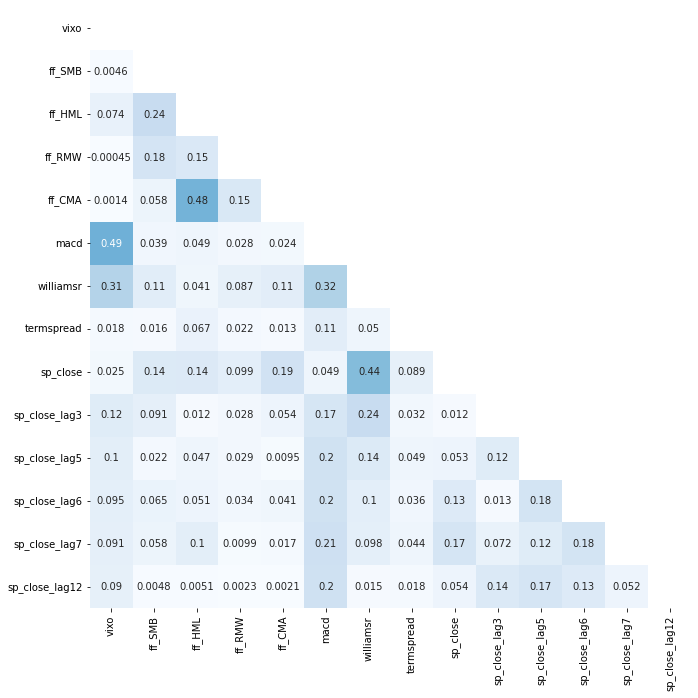

In [12]:
# only rely on correlation not vif
fig_corr = corr_heatmap(X_train, 
             cols,
             size_factor=.7,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

# Model

In [13]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [14]:
model_wrap = ExpandingPredictionOLS(SKLearnWrapOLS(sm.OLS),
                    X_train,
                    y_train,
                    X_test,
                    y_test)

# Out of sample eval

In [15]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model_wrap,
            print_results=True)

In [16]:
mval.model_wrapper.model.trained_model.pvalues < .05

vixo              False
ff_SMB             True
ff_HML            False
ff_RMW            False
ff_CMA            False
macd              False
williamsr          True
termspread        False
sp_close           True
sp_close_lag3      True
sp_close_lag5      True
sp_close_lag6      True
sp_close_lag7      True
sp_close_lag12     True
intercept         False
dtype: bool

In [17]:
mval.model_wrapper.model.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     15.64
Date:                Mon, 02 May 2022   Prob (F-statistic):           5.09e-37
Time:                        16:50:53   Log-Likelihood:                 7534.8
No. Observations:                2371   AIC:                        -1.504e+04
Df Residuals:                    2356   BIC:                        -1.495e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
vixo               0.0010      0.001      1.383      0.167      -0.000       0.002
ff_SMB             0.1197      0.038      3.190      0.001       0.046       0.193
ff_HML            -0.0079      0.036     -0.219      0.827      -0.078       0.063
ff_RMW             0.0177      0.057      0.311      0.756      -0.094       0.129
ff_CMA            -0.0508      0.075     -0.677      0.498      -0.198       0.096
macd            4.376e-07   9.59e-06      0.046      0.964   -1.84e-05    1.93e-05
williamsr       2.463e-05   8.78e-06      2.807      0.005    7.42e-06    4.18e-05
termspread        -0.0001      0.003     -0.053      0.958      -0.006       0.005
sp_close          -0.1790      0.024     -7.473      0.000      -0.226      -0.132
sp_close_lag3     -0.0684      0.021     -3.236      0.001      -0.110      -0.027
sp_close_lag5     -0.0829      0.021     -3.963      0.000      -0.124      -0.042
sp_close_lag6      0.1091      0.022      5.017      0.000       0.066       0.152
sp_close_lag7     -0.0932      0.021     -4.417      0.000      -0.135      -0.052
sp_close_lag12    -0.0559      0.021     -2.687      0.007      -0.097      -0.015
intercept         -0.0013      0.002     -0.628      0.530      -0.005       0.003
==============================================================================
Omnibus:                      975.356   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19562.665
Skew:                          -1.443   Prob(JB):                         0.00
Kurtosis:                      16.773   Cond. No.                     1.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
mval.model_wrapper.model.trained_model.bic

-14952.991662342723

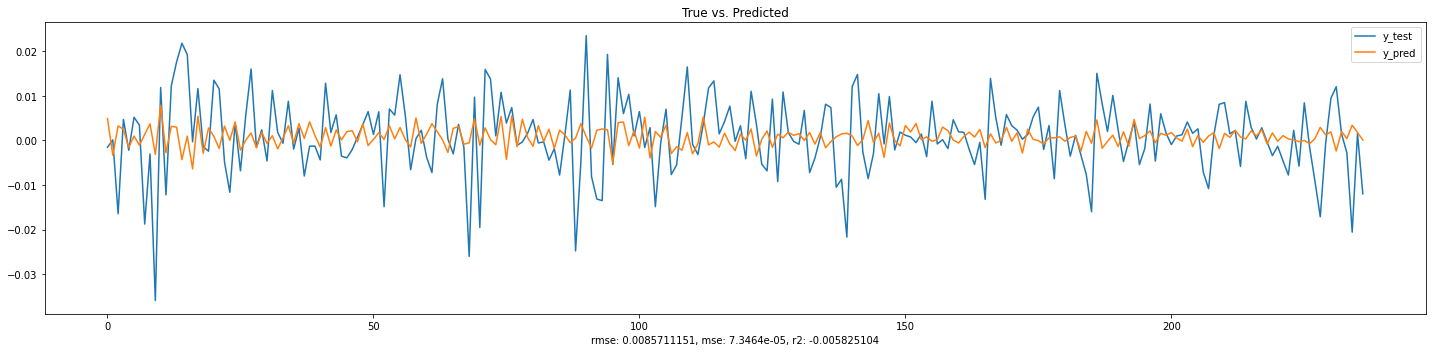

Validation Scores
root mean squared error: 0.0085711151
mean squared error: 7.3464e-05
mean absolute error: 0.0063659194
R2: -0.005825104


In [19]:
fig_true_vs_fit = mval.get_model_performance()

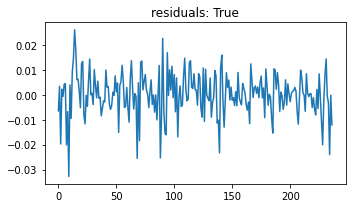

Stationarity Test Results
P-Values: 7.103320219705357e-18
Test-stats: -10.170679957913714
Time series is stationary: True
Number of lags used: 2




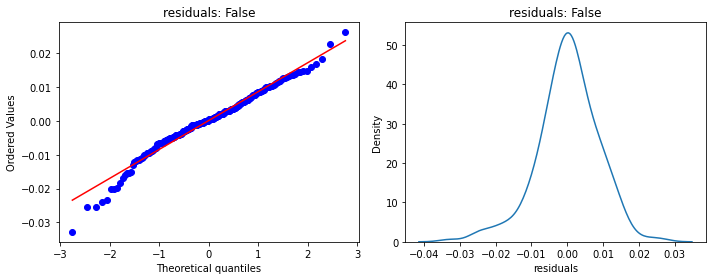

Normality Test Results
P-Values: 0.00013297224315769577
Test-stats: 17.85074029917086
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


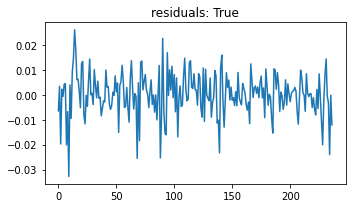

Test for Heteroskedasticity
Test p-value: 0.02918376913661023
Heteroskedasticity is present: True


Ttest_1sampResult(statistic=0.2110360347202706, pvalue=0.833041264825211)
TTest one sample for mean: 0
Test statistics: 0.2110360347202706
Test pvalue: 0.833041264825211
Population mean is equal to 0: True


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 1.827 < 2.5
First order autocorrlation is not present: : True



Ljung Box test
Pvalue: 0.05664205477474656
H0 the residuals are idd can be rejected: False


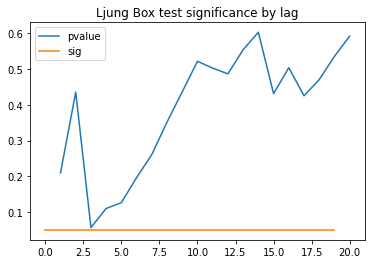

In [20]:
stat, norm, hetero, durbin_wats, zero_mean, idd_ser = mval.analyse_resids()

In [21]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(durbin_watson=durbin_wats)
data_dict["model_metrics"].update(idd_resid=idd_ser)
data_dict["model_metrics"].update(resid_zero_mean=zero_mean)
data_dict["model_metrics"].update(aic=mval.model_wrapper.model.trained_model.aic)
data_dict["model_metrics"].update(bic=mval.model_wrapper.model.trained_model.bic)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid)

data_dict['model_metrics'].update(y_pred=mval.model_wrapper.y_pred)
data_dict['model_metrics'].update(y_test=mval.model_wrapper.y_test)
data_dict['model_metrics'].update(y_prices=df_w.sp_true_vals.iloc[y_test.index[0]:])

# Save model

In [29]:
save_model(model=mval.model_wrapper, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_true_vs_fit, fig_corr], 
           fig_titles=['fig_truefit', 'fig_corr'],
           model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-05-02_ols_daily_FF_TS_VX_years2021_2012_sp_close_lead1"? (y/n)


 y
